### 7. LightGBM

- XGBoost에 비해 학습에 걸리는 시간과 메모리 사용량은 상대적으로 적지만 예측 성능은 큰 차이가 없음
- 기능상 XGBoost보다 약간 더 다양함
- 카테고리형 피처의 자동 변환과 이에 따른 최적 노드 분할
- 대용량 데이터에 대한 뛰어난 예측 성능 및 병렬 컴퓨팅 기능 제공
- GPU 지원
- 적은 데이터 세트에 적용할 경우 과적합 발생하기 쉬움(10,000건 이하)
- 파이썬 래퍼용만 개발됐으나 사이킷런 래퍼 LightGBM이 추가로 개발됨


- 리프 중심 트리 분할(Leaf Wise)방식 사용
    - 최대 손실값(max delta loss)를 가지는 리프 노드를 지속적으로 분할하면서 트리 깊이 깊어지고 비대칭적 규칙 트리 생성
    - 학습을 반복할수록 균형 트리 분할 방식보다 예측 오류 손시 최소화할 수 있음
    

- 기존 대부분 트리 기반 알고리즘은 균형 트리 분할(Level Wise)방식 사용
    - 최대한 균형 잡힌 트리를 유지하면서 분할하므로 트리의 깊이 최소화
    - 오버피팅에 보다 더 강한 구조 but 균형을 맞추기 위한 시간 필요
    
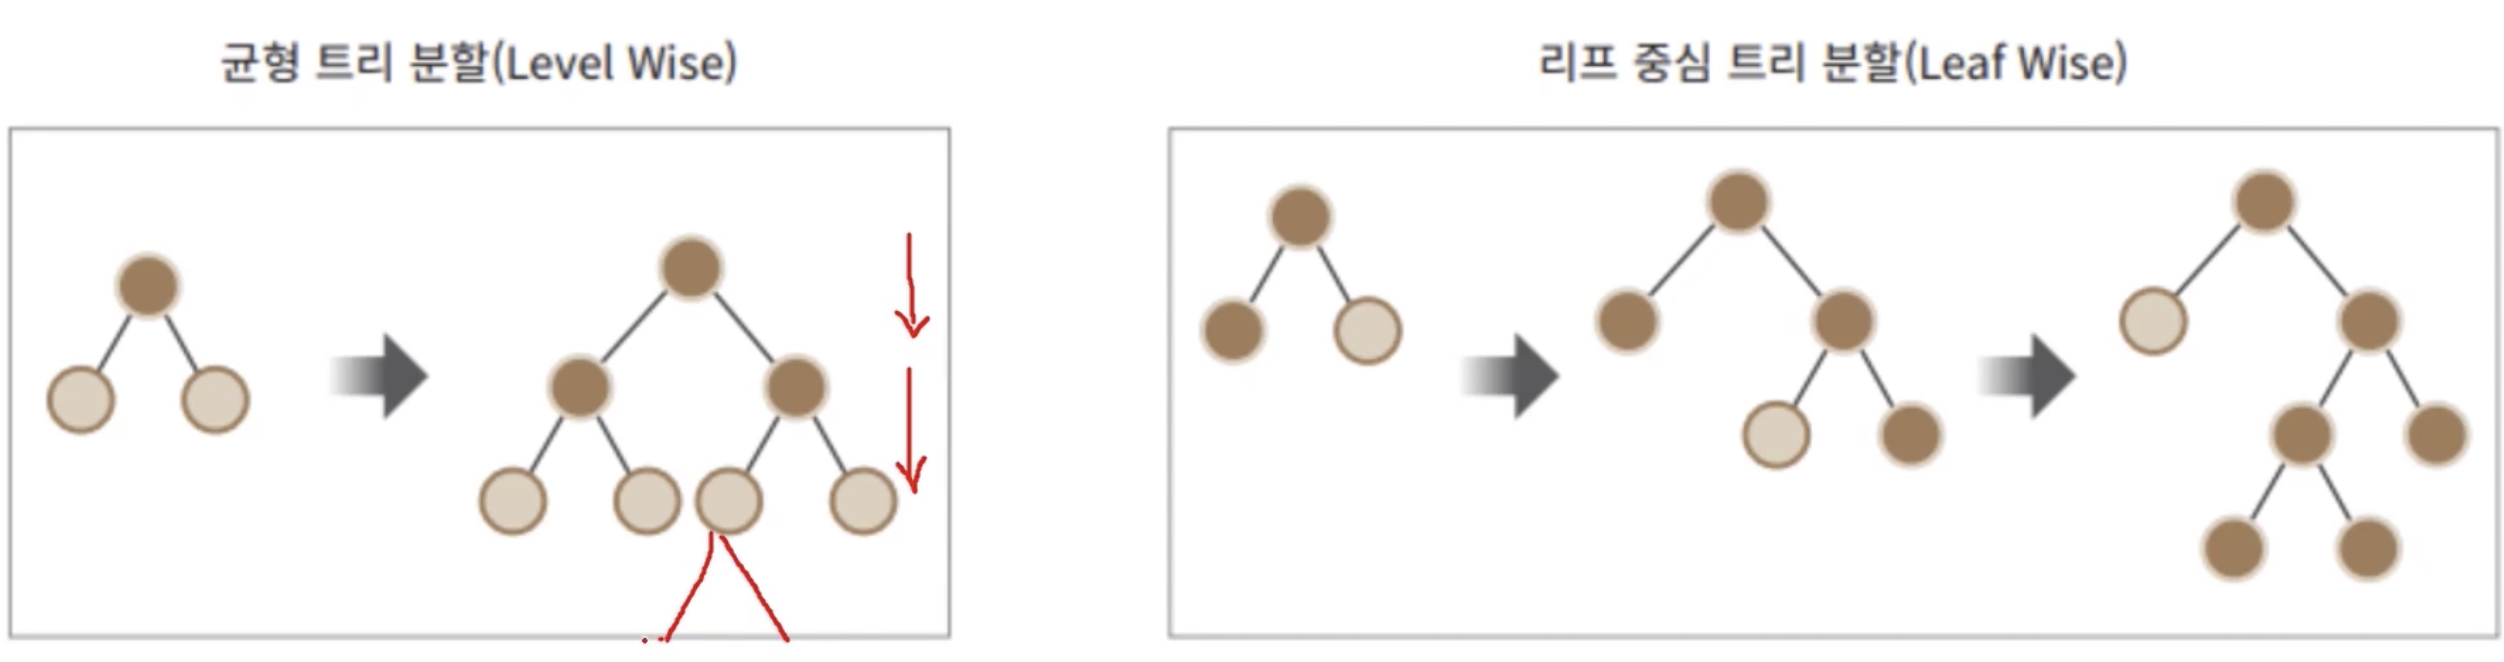

#### LightGBM 하이퍼 파라미터

|파라미터|기본값|설명|
|---|:---:|---:|
|`num_iterations`|100|반복 수행하려는 트리 개수 지정/클 수록 예측 성능 높일 수 있으나 너무 크면 과적합으로 성능 저하|
|`learning_rate`|0.1|0~1사이 값으로 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값/n_estimators를 크게하고 learning_rate를 작게해서 예측 성능 향상시킬 수 있으나 과적합 이슈와 학습시간 길어질 수 있음|
|`max_depth`|-1|0보다 작은 값 지정하면 깊이에 제한 없음|
|`min_data_in_leaf`|20|리프노드가 되기 위한 최소한으로 필요한 레코드 수/과적합 제어|
|`num_leaves`|31|하나의 트리가 가질 수 있는 최대 리프 개수|
|`boosting`|gbdt|부스팅 트리를 생성하는 알고리즘 기술 / gbdt:그래디언트부스팅,rf:랜덤포레스트|
|`bagging_fraction`|1.0|데이터 샘플링하는 비율 지정/과적합 제어|
|`feature_fraction`|1.0|개별 트리 학습시마다 무작위로 선택하는 피처 비율/과적합 제어|
|`lambda_l2`|0.0|L2 regularization 제어 위한 값/피처 개수 많을 시 적용 검토/ 클수록 과적합 감소 효과|
|`lambda_l1`|0.0|L1 regularization 제어 위한 값/ 클수록 과적합 감소 효과|
|`objective`|**Learning Task 파라미터**|최소값을 가져야 할 손실함수 정의|

#### 하이퍼 파라미터 튜닝 방안
- 기본 튜닝 방안   
    - num_leaves의 개수 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정해 보델 복잡도 줄이기
- 부스팅 계열 튜닝에서 기본 튜닝 방안
    - learning_rate 작게 하면서 n_estimators 크게 하기
    - n_estimators가 너무 크면 과적합 가능성 있음
- 과적합 제어
    - reg_lambda, reg_alpha 같은 regularization 적용
    - colsample_bytree, subsample 파라미터 적용해 학습 데이터에 사용할 피처 개수나 데이터 샘플링 레코드 개수 줄이기

#### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
|파이썬 래퍼 LightGBM|사이킷런 래퍼 LightGBM| 사이킷런 래퍼 XGBoost|
|---|:---:|---:|
|num_iterations|n_estimators|n_estimators|
|learning_rate|learning_rate|learning_rate|
|max_depth|max_depth|max_depth|
|min_data_in_leaf|min_child_samples|N/A
|bagging_fraction|subsample|subsample|
|feature_fraction|colsample_bytree|colsample_bytree
|lambda_l2|reg_lambda|reg_lambda
|lambda_l1|reg_alpha|reg_alpha
|early_stopping_round|early_stopping_rounds|early_stopping_rounds
|num_leaves|num_leaves|N/A
|min_sum_hessian_in_leaf|min_child_weight|min_child_weight

#### LightGBM 적용 - 위스코신 유방암 예측

In [2]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score, f1_score,confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state =156)

X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행
evals = [(X_tr, y_tr),(X_val,y_val)]
lgbm_wrapper.fit(X_tr,y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

C:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9877


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

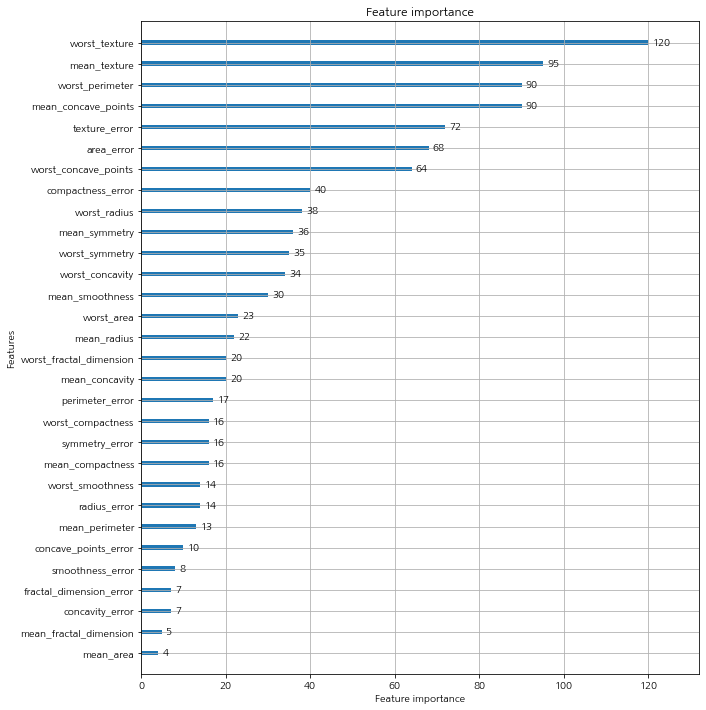

In [6]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

### 8. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

- Grid Search는 튜닝할 하이퍼 파라미터 개수가 많을 경우 최적화 수행 시간이 오래걸림
- 개별 하이퍼 파라미터 값의 범위가 넓거나 학습 데이터가 대용량일 경우 더욱 늘어남
- 실무의 대용량 학습 데이터에 XGBoost나 LightGBM의 하이퍼 파라미터 튜닝 시에는 베이지안 최적화 기법 사용

#### 베이지안 최적화 개요
- 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 베이지안 확률에 기반을 두고 있는 최적화 기법
- 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해나가며 최적 함수 모델 생성

**중요 구성 요소**
- 대체 모델(Surrogate Model)
    - 획득 함수로부터 최적 함수를 예측할 수 있는 입력값 추천 받은 뒤 이를 기반으로 최적 함수 모델 개선
- 획득 함수(Acquisition Function)
    - 개선된 대체 모델을 기반으로 최적 입력값 계산
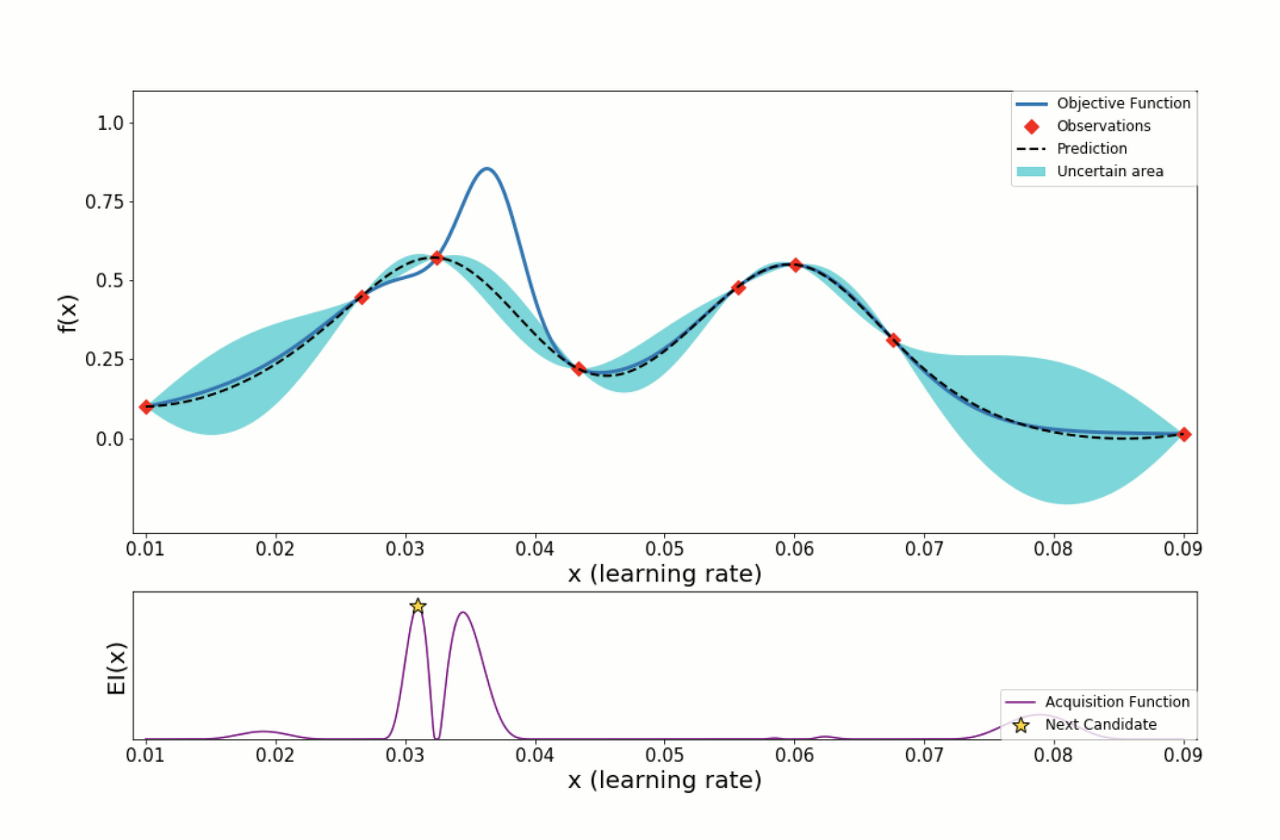
1. 최초에 랜덤하게 하이퍼 파라미터들 샘풀링하고 성능 결과 관측
    - 파란색 선은, 우리가 찾으려고 하는 목표 최적 함수 f(x) 를 나타냄
2. 관측값 기반으로 대체 모델은 최적 함수 추정
    - 검정색 점선은, 지금까지 관측한 데이터를 바탕으로 우리가 예측한 estimated function 을 의미
    - 검정색 점선 주변에 있는 파란 영역은, 목적함수 f(x) 가 존재할만한 신뢰 구간(function의 variance)를 의미, 추정 함수의 불확실성 나타냄
    - y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터 -> 최적 관측값
3. 추정된 최적 함수를 기반으로 획득 함수 EI(x)로 다음 관측할 하이퍼 파라미터 값 계산
    - 이전 최적 관측값보다 더 큰 최대값을 가질 가능성이 있는 높은 지점 찾아 다음에 관측할 하이퍼 파라미터 대체 모델에 전달
    - Acquisition function 값이 컸던 지점을 확인하고, 해당 지점의 hyperparameter 를 다음 입력 값으로 사용
4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값 기반으로 대체 모델 갱신되고 다시 최적 함수 예측 추정
    - hyperparamter 에 따라 estimated function 을 계속 갱신 하면, estimation function 과 목적 함수 f(x) 가 흡사해짐
    - 모델 불확실성 개선됨
- 대체 모델이 최적 함수 추정 시 일반적으로 가우시안 프로세스 적용
- HyperOpt는 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator) 사용

#### HyerOpt 사용하기
- 활용 주요 로직
    1. 입력 변수명과 입력값의 검색 공간 설정 / 파이썬 딕셔너리 형태로 설정되야함 (키:입력 변수명, value:해당 입력 변수의 검색 공간)
    2. 목적 함수 설정 / 변수값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정값 반환하는 구조로 만들어야함
    3. 목적 함수의 반환 최소값을 가지는 최적 입력값 유추 / fmin() 함수 사용

In [9]:
# hp 모듈 : 입력값의 검색 공간 다양하게 설정할 수 있도록 함수 제공
from hyperopt import hp
# -10 ~ 10까지 1간격 가지는 입력 변수 x와 -15~15까지 1간격으로 입력 변수 y 설정
search_space = {'x':hp.quniform('x',-10,10,1),'y':hp.quniform('y',-15,15,1)}

In [10]:
# 목적 함수 생성
from hyperopt import STATUS_OK

# 딕셔너리 형태로 반환 시 loss와 status키 값 설정해서 반환해야 함
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

**fmin 함수 주요 인자**

|인자명|설명|
|---|---:|
|`fn`|목적 함수|
|`space`|검색 공간 딕셔너리|
|`algo`|베이지안 최적화 전용 알고리즘/기본적으로 tpe.suggest|
|`max_evals`|최적 입력값 찾기 위한 입력값 시도 횟수|
|`trials`|최적 입력값 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과 저장|
|`rstate`|fmin()수행할 때마다 동일한 결과값 가질 수 있도록 설정하는 랜덤 시드, 일반적으로 잘 적용 안함|

In [12]:
from hyperopt import fmin, tpe, Trials
# 입력 결과값 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최소값 반환하는 최적 입력 변수값을 5번의 입력값 시도로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 250.70trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [13]:
# max_evals 20으로 설정
trial_val = Trials()

# 목적 함수의 최소값 반환하는 최적 입력 변수값을 5번의 입력값 시도로 찾아냄
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 339.88trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [14]:
trial_val.results # 목적 함수 반환값

[{'loss': -64.0, 'status': 'ok'},
 {'loss': -184.0, 'status': 'ok'},
 {'loss': 56.0, 'status': 'ok'},
 {'loss': -224.0, 'status': 'ok'},
 {'loss': 61.0, 'status': 'ok'},
 {'loss': -296.0, 'status': 'ok'},
 {'loss': -40.0, 'status': 'ok'},
 {'loss': 281.0, 'status': 'ok'},
 {'loss': 64.0, 'status': 'ok'},
 {'loss': 100.0, 'status': 'ok'},
 {'loss': 60.0, 'status': 'ok'},
 {'loss': -39.0, 'status': 'ok'},
 {'loss': 1.0, 'status': 'ok'},
 {'loss': -164.0, 'status': 'ok'},
 {'loss': 21.0, 'status': 'ok'},
 {'loss': -56.0, 'status': 'ok'},
 {'loss': 284.0, 'status': 'ok'},
 {'loss': 176.0, 'status': 'ok'},
 {'loss': -171.0, 'status': 'ok'},
 {'loss': 0.0, 'status': 'ok'}]

In [15]:
trial_val.vals # 입력 변수 값

{'x': [-6.0,
  -4.0,
  4.0,
  -4.0,
  9.0,
  2.0,
  10.0,
  -9.0,
  -8.0,
  -0.0,
  -0.0,
  1.0,
  9.0,
  6.0,
  9.0,
  2.0,
  -2.0,
  -4.0,
  7.0,
  -0.0],
 'y': [5.0,
  10.0,
  -2.0,
  12.0,
  1.0,
  15.0,
  7.0,
  -10.0,
  0.0,
  -5.0,
  -3.0,
  2.0,
  4.0,
  10.0,
  3.0,
  3.0,
  -14.0,
  -8.0,
  11.0,
  -0.0]}

In [16]:
# DataFrame으로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


#### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화
- HyperOpt는 입력값과 반환 값이 모두 실수형이기 때문에 하이퍼 파라미터 입력 시 형변환 필요
- HyperOpt의 목적 함수는 최소값을 반환할 수 있도록 최적화해야 하므로 성능 값이 클수록 좋은 지표일 경우 -1 곱해줘야함
    - ex) 정확도 ↔ MAE, RMSE 등은 -1 곱할 필요 없음

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr,X_val,y_tr,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [18]:
xgb_search_space = {'max_depth':hp.quniform('max_depth',5,20,1),
                   'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                   'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                   'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

In [20]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [23]:
trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space,
           algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:',best)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▉                                               | 1/50 [00:00<00:22,  2.16trial/s, best loss: -0.9472958057395143]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|█▉                                              | 2/50 [00:00<00:21,  2.28trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|██▉                                             | 3/50 [00:01<00:20,  2.33trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|███▊                                            | 4/50 [00:01<00:19,  2.32trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|████▊                                           | 5/50 [00:02<00:18,  2.46trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█████▊                                          | 6/50 [00:02<00:17,  2.51trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|██████▋                                         | 7/50 [00:02<00:17,  2.46trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|███████▋                                        | 8/50 [00:03<00:17,  2.44trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|████████▋                                       | 9/50 [00:03<00:16,  2.49trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|█████████▍                                     | 10/50 [00:04<00:16,  2.39trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██████████▎                                    | 11/50 [00:04<00:15,  2.44trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|███████████▎                                   | 12/50 [00:04<00:15,  2.48trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|████████████▏                                  | 13/50 [00:05<00:14,  2.57trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|█████████████▏                                 | 14/50 [00:05<00:14,  2.42trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|██████████████                                 | 15/50 [00:06<00:14,  2.36trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███████████████                                | 16/50 [00:06<00:14,  2.39trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███████████████▉                               | 17/50 [00:07<00:15,  2.10trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|████████████████▉                              | 18/50 [00:07<00:14,  2.20trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|█████████████████▊                             | 19/50 [00:08<00:14,  2.20trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|███████████████████▏                            | 20/50 [00:08<00:13,  2.28trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|████████████████████▏                           | 21/50 [00:08<00:12,  2.26trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|█████████████████████                           | 22/50 [00:09<00:12,  2.26trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|██████████████████████                          | 23/50 [00:09<00:11,  2.40trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|███████████████████████                         | 24/50 [00:10<00:11,  2.25trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|████████████████████████                        | 25/50 [00:10<00:11,  2.18trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|████████████████████████▍                      | 26/50 [00:11<00:10,  2.29trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████████████████████████▍                     | 27/50 [00:11<00:09,  2.33trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|██████████████████████████▎                    | 28/50 [00:11<00:09,  2.25trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|███████████████████████████▎                   | 29/50 [00:12<00:08,  2.36trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|████████████████████████████▏                  | 30/50 [00:12<00:08,  2.25trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|█████████████████████████████▏                 | 31/50 [00:13<00:08,  2.14trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████████████████████████████                 | 32/50 [00:13<00:08,  2.15trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|███████████████████████████████                | 33/50 [00:14<00:07,  2.31trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|███████████████████████████████▉               | 34/50 [00:14<00:06,  2.34trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|████████████████████████████████▉              | 35/50 [00:15<00:06,  2.30trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|█████████████████████████████████▊             | 36/50 [00:15<00:06,  2.31trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|██████████████████████████████████▊            | 37/50 [00:15<00:05,  2.27trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████████████████████████████████▋           | 38/50 [00:16<00:05,  2.16trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|████████████████████████████████████▋          | 39/50 [00:16<00:05,  2.16trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|█████████████████████████████████████▌         | 40/50 [00:17<00:04,  2.14trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|██████████████████████████████████████▌        | 41/50 [00:17<00:04,  2.20trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|███████████████████████████████████████▍       | 42/50 [00:18<00:03,  2.24trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████████████████████████████████████▍      | 43/50 [00:18<00:02,  2.35trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|█████████████████████████████████████████▎     | 44/50 [00:18<00:02,  2.40trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|██████████████████████████████████████████▎    | 45/50 [00:19<00:02,  2.33trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|███████████████████████████████████████████▏   | 46/50 [00:19<00:01,  2.41trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|████████████████████████████████████████████▏  | 47/50 [00:20<00:01,  2.49trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████████████████████████████████████████  | 48/50 [00:20<00:00,  2.55trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|██████████████████████████████████████████████ | 49/50 [00:21<00:00,  2.45trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|███████████████████████████████████████████████| 50/50 [00:21<00:00,  2.33trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [24]:
print('colsample_bytree:{0}, learning_rate:{1}, min_child_weight:{3}'.format(round(best['colsample_bytree'],5),
                                                                            round(best['learning_rate'],5),
                                                                            int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, min_child_weight:2


In [29]:
# 도출된 최적 하이퍼 파라미터로 XGBClassifier 재학습 후 성능 평가
xgb_wrapper = XGBClassifier(n_estimators= 400, max_depth=int(best['max_depth']),
                           min_child_weight=int(best['min_child_weight']),
                           learning_rate=round(best['colsample_bytree'],5),
                           colsample_bytree=round(best['colsample_bytree'],5))
evals = [(X_tr, y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.33704	validation_1-logloss:0.46145
[1]	validation_0-logloss:0.19944	validation_1-logloss:0.39298
[2]	validation_0-logloss:0.13024	validation_1-logloss:0.34734
[3]	validation_0-logloss:0.09372	validation_1-logloss:0.32993
[4]	validation_0-logloss:0.06697	validation_1-logloss:0.30786
[5]	validation_0-logloss:0.05531	validation_1-logloss:0.32012
[6]	validation_0-logloss:0.04739	validation_1-logloss:0.31073
[7]	validation_0-logloss:0.04110	validation_1-logloss:0.30579
[8]	validation_0-logloss:0.03403	validation_1-logloss:0.28622
[9]	validation_0-logloss:0.03033	validation_1-logloss:0.28585
[10]	validation_0-logloss:0.02733	validation_1-logloss:0.28478
[11]	validation_0-logloss:0.02550	validation_1-logloss:0.27399
[12]	validation_0-logloss:0.02463	validation_1-logloss:0.26693
[13]	validation_0-logloss:0.02306	validation_1-logloss:0.27336
[14]	validation_0-logloss:0.02225	validation_1-logloss:0.28350
[15]	validation_0-logloss:0.02149	validation_1-logloss:0.28218
[1

In [31]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 3 74]]
정확도: 0.9386, 정밀도: 0.9487, 재현율: 0.9610, F1: 0.9548, AUC:0.9905


### 9. 분류 실습 - 캐글 산탄데르 고객 만족 예측
- 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부 예측
- 1 : 불만 가진 고객, 0: 만족한 고객
- ROC-AUC로 평가

#### 데이터 전처리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [3]:
cust_df = pd.read_csv('./data/santander-customer-satisfaction/train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
# Null값 확인
cust_df.info()
# float형 111개, int형 260개, Null값 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
# Target값 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율 {0:.2f}'.format(unsatisfied_cnt/total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율 0.04


In [7]:
cust_df.describe()
# var3의 경우 최소값이 -999999임. NaN이나 특정 예외값을 변환한 값이라고 추측할 수 있음.

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [9]:
print(cust_df.var3.value_counts()[:10])
# -999999는 편차가 너무 심하므로 최빈값인 2로 변환
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_label = cust_df.iloc[:,-1]
print('피처 데이터 shape',X_features.shape)

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64
피처 데이터 shape (76020, 369)


In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)
# 비대칭한 데이터 세트에서 Target값이 비슷하게 추출됐는지 확인
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape, X_test.shape)

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)
# 원본 데이터와 유사하게 불만족 값이 4%가 되도록 만들어짐

(60816, 369) (15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [11]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, learning_rate = 0.05, random_state=156)

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82059	validation_1-auc:0.81873
[1]	validation_0-auc:0.82427	validation_1-auc:0.82085
[2]	validation_0-auc:0.82489	validation_1-auc:0.82124
[3]	validation_0-auc:0.82687	validation_1-auc:0.82436
[4]	validation_0-auc:0.82886	validation_1-auc:0.82462
[5]	validation_0-auc:0.82927	validation_1-auc:0.82508
[6]	validation_0-auc:0.83167	validation_1-auc:0.82748
[7]	validation_0-auc:0.83206	validation_1-auc:0.82864
[8]	validation_0-auc:0.83247	validation_1-auc:0.82796
[9]	validation_0-auc:0.83370	validation_1-auc:0.82783
[10]	validation_0-auc:0.83387	validation_1-auc:0.82783
[11]	validation_0-auc:0.83717	validation_1-auc:0.82881
[12]	validation_0-auc:0.83960	validation_1-auc:0.83023
[13]	validation_0-auc:0.83924	validation_1-auc:0.82882
[14]	validation_0-auc:0.84196	validation_1-auc:0.83103
[15]	validation_0-auc:0.84256	validation_1-auc:0.83253
[16]	validation_0-auc:0.84314	validation_1-auc:0.83254
[17]	validation_0-auc:0.84425	validation_1-auc:0.83171
[18]	validation_0-au

[149]	validation_0-auc:0.89748	validation_1-auc:0.84069
[150]	validation_0-auc:0.89759	validation_1-auc:0.84071
[151]	validation_0-auc:0.89765	validation_1-auc:0.84084
[152]	validation_0-auc:0.89771	validation_1-auc:0.84081
[153]	validation_0-auc:0.89782	validation_1-auc:0.84079
[154]	validation_0-auc:0.89789	validation_1-auc:0.84076
[155]	validation_0-auc:0.89792	validation_1-auc:0.84078
[156]	validation_0-auc:0.89797	validation_1-auc:0.84072
[157]	validation_0-auc:0.89825	validation_1-auc:0.84066
[158]	validation_0-auc:0.89851	validation_1-auc:0.84055
[159]	validation_0-auc:0.89862	validation_1-auc:0.84051
[160]	validation_0-auc:0.89865	validation_1-auc:0.84050
[161]	validation_0-auc:0.89883	validation_1-auc:0.84030
[162]	validation_0-auc:0.89888	validation_1-auc:0.84030
[163]	validation_0-auc:0.89901	validation_1-auc:0.84035
[164]	validation_0-auc:0.89905	validation_1-auc:0.84031
[165]	validation_0-auc:0.89913	validation_1-auc:0.84026
[166]	validation_0-auc:0.89924	validation_1-auc:

In [14]:
# HyperOpt 이용해 베이지안 최적화 기반으로 XGBoost 하이퍼 파라미터 튜닝
from hyperopt import hp

xgb_search_space = {'max_depth':hp.quniform('max_depth',5,15,1),
                   'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                   'colsample_bytree':hp.uniform('colsample_bytree',0.05,0.95),
                   'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [15]:
# 목적 함수 생성
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_eistimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           colsample_bytree = search_space['colsample_bytree'],
                           learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표 담는 list
    roc_auc_list = []
    
    kf=KFold(n_splits=3)
    for tr_index, val_index in kf.split(X_train):
        X_tr,y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                    eval_set=[(X_tr, y_tr), (X_val, y_val)])
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
        
        return -1*np.mean(roc_auc_list)

In [16]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func,
           space=xgb_search_space,
           algo=tpe.suggest,
           max_evals=10,
           trials=trials, rstate=np.random.default_rng(seed=30))
print('best:',best)

[01:40:44] WARNING: ..\src\learner.cc:576:                                                                                   
Parameters: { "n_eistimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                        
[1]	validation_0-auc:0.82476	validation_1-auc:0.79687                                                                        
[2]	validation_0-auc:0.83317	validation_1-auc:0.80553                                                                        
[3]	validation_0-auc:0.83627	validation_1-auc:0.80753                                                                        
[4]	validation_0-auc:0.83764	validation_1-auc:0.80

[33]	validation_0-auc:0.84538	validation_1-auc:0.79677                                                                       
[34]	validation_0-auc:0.84725	validation_1-auc:0.79780                                                                       
[35]	validation_0-auc:0.85090	validation_1-auc:0.80079                                                                       
[36]	validation_0-auc:0.85316	validation_1-auc:0.80014                                                                       
[37]	validation_0-auc:0.85494	validation_1-auc:0.80004                                                                       
[38]	validation_0-auc:0.85615	validation_1-auc:0.79905                                                                       
[39]	validation_0-auc:0.85802	validation_1-auc:0.79999                                                                       
[40]	validation_0-auc:0.85884	validation_1-auc:0.80007                                                                

[26]	validation_0-auc:0.85750	validation_1-auc:0.81140                                                                       
[27]	validation_0-auc:0.85662	validation_1-auc:0.81007                                                                       
[28]	validation_0-auc:0.85613	validation_1-auc:0.80902                                                                       
[29]	validation_0-auc:0.85826	validation_1-auc:0.81109                                                                       
[30]	validation_0-auc:0.85820	validation_1-auc:0.81051                                                                       
[31]	validation_0-auc:0.85766	validation_1-auc:0.81033                                                                       
[32]	validation_0-auc:0.85823	validation_1-auc:0.81010                                                                       
[33]	validation_0-auc:0.85757	validation_1-auc:0.80956                                                                

[2]	validation_0-auc:0.81399	validation_1-auc:0.78536                                                                        
[3]	validation_0-auc:0.81296	validation_1-auc:0.78288                                                                        
[4]	validation_0-auc:0.82480	validation_1-auc:0.79777                                                                        
[5]	validation_0-auc:0.82412	validation_1-auc:0.79992                                                                        
[6]	validation_0-auc:0.82549	validation_1-auc:0.79902                                                                        
[7]	validation_0-auc:0.83061	validation_1-auc:0.80385                                                                        
[8]	validation_0-auc:0.83908	validation_1-auc:0.81064                                                                        
[9]	validation_0-auc:0.83834	validation_1-auc:0.80642                                                                 

[28]	validation_0-auc:0.86089	validation_1-auc:0.81530                                                                       
[29]	validation_0-auc:0.86357	validation_1-auc:0.81864                                                                       
[30]	validation_0-auc:0.86385	validation_1-auc:0.81835                                                                       
[31]	validation_0-auc:0.86404	validation_1-auc:0.81790                                                                       
[32]	validation_0-auc:0.86486	validation_1-auc:0.81751                                                                       
[33]	validation_0-auc:0.86518	validation_1-auc:0.81656                                                                       
[34]	validation_0-auc:0.86716	validation_1-auc:0.81917                                                                       
[35]	validation_0-auc:0.87095	validation_1-auc:0.82248                                                                

[54]	validation_0-auc:0.92225	validation_1-auc:0.83181                                                                       
[55]	validation_0-auc:0.92338	validation_1-auc:0.83181                                                                       
[56]	validation_0-auc:0.92361	validation_1-auc:0.83162                                                                       
[57]	validation_0-auc:0.92443	validation_1-auc:0.83122                                                                       
[58]	validation_0-auc:0.92517	validation_1-auc:0.83151                                                                       
[59]	validation_0-auc:0.92616	validation_1-auc:0.83097                                                                       
[60]	validation_0-auc:0.92685	validation_1-auc:0.83062                                                                       
[61]	validation_0-auc:0.92747	validation_1-auc:0.83039                                                                

[18]	validation_0-auc:0.90743	validation_1-auc:0.82670                                                                       
[19]	validation_0-auc:0.91123	validation_1-auc:0.82806                                                                       
[20]	validation_0-auc:0.91344	validation_1-auc:0.82887                                                                       
[21]	validation_0-auc:0.91648	validation_1-auc:0.82844                                                                       
[22]	validation_0-auc:0.92021	validation_1-auc:0.82741                                                                       
[23]	validation_0-auc:0.92315	validation_1-auc:0.82690                                                                       
[24]	validation_0-auc:0.92587	validation_1-auc:0.82656                                                                       
[25]	validation_0-auc:0.92811	validation_1-auc:0.82649                                                                

In [19]:
# 도출된 최적 하이퍼 파라미터 기반으로 XGBClassifier 재학습
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'],5),
                       max_depth=int(best['max_depth']),
                       min_child_weight=int(best['min_child_weight']),
                       colsample_bytree = round(best['colsample_bytree'],5))
xgb_clf.fit(X_tr,y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82144	validation_1-auc:0.82219
[1]	validation_0-auc:0.82645	validation_1-auc:0.82080
[2]	validation_0-auc:0.83683	validation_1-auc:0.83018
[3]	validation_0-auc:0.83583	validation_1-auc:0.82706
[4]	validation_0-auc:0.83958	validation_1-auc:0.82966
[5]	validation_0-auc:0.84276	validation_1-auc:0.83192
[6]	validation_0-auc:0.84417	validation_1-auc:0.82986
[7]	validation_0-auc:0.84617	validation_1-auc:0.83147
[8]	validation_0-auc:0.84920	validation_1-auc:0.83274
[9]	validation_0-auc:0.85219	validation_1-auc:0.83090
[10]	validation_0-auc:0.85214	validation_1-auc:0.82688
[11]	validation_0-auc:0.85108	validation_1-auc:0.82455
[12]	validation_0-auc:0.85353	validation_1-auc:0.82639
[13]	validation_0-auc:0.85696	validation_1-auc:0.82655
[14]	validation_0-auc:0.85854	validation_1-auc:0.82833
[15]	validation_0-auc:0.86013	validation_1-auc:0.83065
[16]	validation_0-auc:0.86238	validation_1-auc:0.83148
[17]	validation_0-auc:0.86328	validation_1-auc:0.83117
[18]	validation_0-au

[149]	validation_0-auc:0.91209	validation_1-auc:0.83918
[150]	validation_0-auc:0.91211	validation_1-auc:0.83922
[151]	validation_0-auc:0.91216	validation_1-auc:0.83914
[152]	validation_0-auc:0.91221	validation_1-auc:0.83911
[153]	validation_0-auc:0.91268	validation_1-auc:0.83881
[154]	validation_0-auc:0.91272	validation_1-auc:0.83874
[155]	validation_0-auc:0.91313	validation_1-auc:0.83896
[156]	validation_0-auc:0.91320	validation_1-auc:0.83885
ROC AUC:0.8433


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

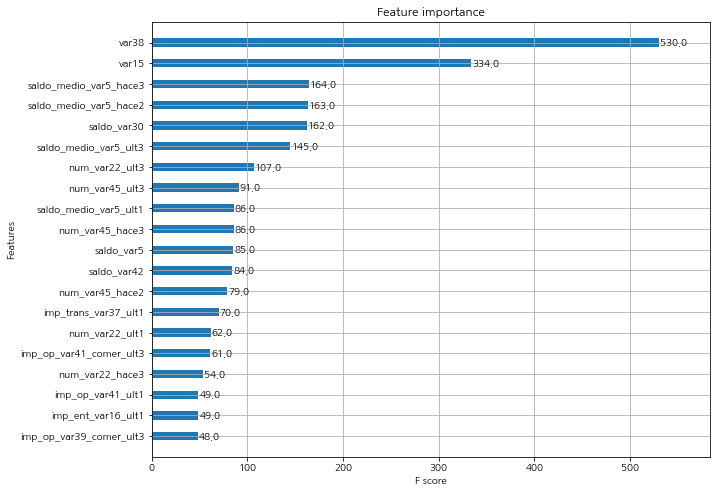

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

#### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [21]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.823599	training's binary_logloss: 0.155161	valid_1's auc: 0.813415	valid_1's binary_logloss: 0.165141
[2]	training's auc: 0.827482	training's binary_logloss: 0.149676	valid_1's auc: 0.819803	valid_1's binary_logloss: 0.160321
[3]	training's auc: 0.83631	training's binary_logloss: 0.145701	valid_1's auc: 0.824371	valid_1's binary_logloss: 0.157036
[4]	training's auc: 0.839721	training's binary_logloss: 0.14257	valid_1's auc: 0.829112	valid_1's binary_logloss: 0.154081
[5]	training's auc: 0.843568	training's binary_logloss: 0.140029	valid_1's auc: 0.832428	valid_1's binary_logloss: 0.151832
[6]	training's auc: 0.847825	training's binary_logloss: 0.137897	valid_1's auc: 0.833423	valid_1's binary_logloss: 0.15011
[7]	training's auc: 0.851255	training's binary_logloss: 0.136054	valid_1's auc: 0.834356	valid_1's binary_logloss: 0.148506
[8]	training's auc: 0.853931	training's binary_logloss: 0.134532	valid_1's auc: 0.83534	valid_1's binary_logloss: 0.147202
[9]	training

[70]	training's auc: 0.917489	training's binary_logloss: 0.108686	valid_1's auc: 0.834587	valid_1's binary_logloss: 0.140819
[71]	training's auc: 0.9177	training's binary_logloss: 0.108543	valid_1's auc: 0.834263	valid_1's binary_logloss: 0.140847
[72]	training's auc: 0.918174	training's binary_logloss: 0.108349	valid_1's auc: 0.834549	valid_1's binary_logloss: 0.140851
[73]	training's auc: 0.918817	training's binary_logloss: 0.108125	valid_1's auc: 0.834872	valid_1's binary_logloss: 0.140756
[74]	training's auc: 0.919025	training's binary_logloss: 0.108003	valid_1's auc: 0.834652	valid_1's binary_logloss: 0.140788
[75]	training's auc: 0.919156	training's binary_logloss: 0.107885	valid_1's auc: 0.834522	valid_1's binary_logloss: 0.140774
[76]	training's auc: 0.919684	training's binary_logloss: 0.107637	valid_1's auc: 0.834359	valid_1's binary_logloss: 0.140839
[77]	training's auc: 0.920027	training's binary_logloss: 0.107453	valid_1's auc: 0.834559	valid_1's binary_logloss: 0.140787
[7

In [23]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves',32,64,1),
    'max_depth':hp.quniform('max_depth',100,160,1),
    'min_child_samples':hp.quniform('min_child_samples',60,100,1),
    'subsample':hp.uniform('subsample',0.7,1),
    'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [24]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_eistimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample = search_space['subsample'],
                            learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표 담는 list
    roc_auc_list = []
    
    kf=KFold(n_splits=3)
    for tr_index, val_index in kf.split(X_train):
        X_tr,y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                    eval_set=[(X_tr, y_tr), (X_val, y_val)])
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
        
        return -1*np.mean(roc_auc_list)

In [25]:
trials = Trials()

best = fmin(fn=objective_func,
           space=lgbm_search_space,
           algo=tpe.suggest,
           max_evals=10,
           trials=trials, rstate=np.random.default_rng(seed=30))
print('best:',best)

[LightGBM] [Warning] Unknown parameter: n_eistimators                                                                        
[1]	training's auc: 0.82736	training's binary_logloss: 0.162294	valid_1's auc: 0.804818	valid_1's binary_logloss: 0.163544   
[2]	training's auc: 0.828309	training's binary_logloss: 0.160269	valid_1's auc: 0.804585	valid_1's binary_logloss: 0.161866  
[3]	training's auc: 0.833368	training's binary_logloss: 0.158478	valid_1's auc: 0.806871	valid_1's binary_logloss: 0.16038   
[4]	training's auc: 0.834671	training's binary_logloss: 0.156852	valid_1's auc: 0.80706	valid_1's binary_logloss: 0.159053   
[5]	training's auc: 0.837783	training's binary_logloss: 0.155354	valid_1's auc: 0.811645	valid_1's binary_logloss: 0.157793  
[6]	training's auc: 0.839052	training's binary_logloss: 0.153966	valid_1's auc: 0.81271	valid_1's binary_logloss: 0.156635   
[7]	training's auc: 0.841216	training's binary_logloss: 0.152691	valid_1's auc: 0.815103	valid_1's binary_logloss: 0.1

[29]	training's auc: 0.916597	training's binary_logloss: 0.1102	valid_1's auc: 0.827497	valid_1's binary_logloss: 0.136912   
[30]	training's auc: 0.918061	training's binary_logloss: 0.109591	valid_1's auc: 0.827686	valid_1's binary_logloss: 0.136921 
[31]	training's auc: 0.919708	training's binary_logloss: 0.109071	valid_1's auc: 0.827489	valid_1's binary_logloss: 0.136961 
[32]	training's auc: 0.920786	training's binary_logloss: 0.108496	valid_1's auc: 0.827387	valid_1's binary_logloss: 0.136997 
[33]	training's auc: 0.922615	training's binary_logloss: 0.108007	valid_1's auc: 0.827552	valid_1's binary_logloss: 0.136998 
[34]	training's auc: 0.924119	training's binary_logloss: 0.107467	valid_1's auc: 0.827417	valid_1's binary_logloss: 0.137122 
[35]	training's auc: 0.925215	training's binary_logloss: 0.106896	valid_1's auc: 0.82713	valid_1's binary_logloss: 0.137248  
[36]	training's auc: 0.926354	training's binary_logloss: 0.106241	valid_1's auc: 0.826635	valid_1's binary_logloss: 0.

[22]	training's auc: 0.88238	training's binary_logloss: 0.126723	valid_1's auc: 0.830295	valid_1's binary_logloss: 0.138243  
[23]	training's auc: 0.883776	training's binary_logloss: 0.126165	valid_1's auc: 0.830692	valid_1's binary_logloss: 0.137971 
[24]	training's auc: 0.88482	training's binary_logloss: 0.125529	valid_1's auc: 0.830506	valid_1's binary_logloss: 0.137746  
[25]	training's auc: 0.885832	training's binary_logloss: 0.124934	valid_1's auc: 0.830799	valid_1's binary_logloss: 0.137556 
[26]	training's auc: 0.887091	training's binary_logloss: 0.124379	valid_1's auc: 0.830879	valid_1's binary_logloss: 0.13733  
[27]	training's auc: 0.888004	training's binary_logloss: 0.123857	valid_1's auc: 0.830649	valid_1's binary_logloss: 0.137147 
[28]	training's auc: 0.889028	training's binary_logloss: 0.123347	valid_1's auc: 0.830946	valid_1's binary_logloss: 0.136992 
[29]	training's auc: 0.889966	training's binary_logloss: 0.12285	valid_1's auc: 0.830753	valid_1's binary_logloss: 0.1

[75]	training's auc: 0.869716	training's binary_logloss: 0.131343	valid_1's auc: 0.829064	valid_1's binary_logloss: 0.139743 
[76]	training's auc: 0.869956	training's binary_logloss: 0.131177	valid_1's auc: 0.829219	valid_1's binary_logloss: 0.139638 
[77]	training's auc: 0.870148	training's binary_logloss: 0.13101	valid_1's auc: 0.829206	valid_1's binary_logloss: 0.139546  
[78]	training's auc: 0.870356	training's binary_logloss: 0.130837	valid_1's auc: 0.829113	valid_1's binary_logloss: 0.139467 
[79]	training's auc: 0.870567	training's binary_logloss: 0.130662	valid_1's auc: 0.829237	valid_1's binary_logloss: 0.139365 
[80]	training's auc: 0.870777	training's binary_logloss: 0.130488	valid_1's auc: 0.82924	valid_1's binary_logloss: 0.139276  
[81]	training's auc: 0.870982	training's binary_logloss: 0.130333	valid_1's auc: 0.829229	valid_1's binary_logloss: 0.139198 
[82]	training's auc: 0.871134	training's binary_logloss: 0.130172	valid_1's auc: 0.829149	valid_1's binary_logloss: 0.

[22]	training's auc: 0.894736	training's binary_logloss: 0.118516	valid_1's auc: 0.828105	valid_1's binary_logloss: 0.136145 
[23]	training's auc: 0.895882	training's binary_logloss: 0.118009	valid_1's auc: 0.827992	valid_1's binary_logloss: 0.136131 
[24]	training's auc: 0.897189	training's binary_logloss: 0.117575	valid_1's auc: 0.827706	valid_1's binary_logloss: 0.136147 
[25]	training's auc: 0.899366	training's binary_logloss: 0.116946	valid_1's auc: 0.827533	valid_1's binary_logloss: 0.136152 
[26]	training's auc: 0.900319	training's binary_logloss: 0.116455	valid_1's auc: 0.827876	valid_1's binary_logloss: 0.136139 
[27]	training's auc: 0.901541	training's binary_logloss: 0.115921	valid_1's auc: 0.827704	valid_1's binary_logloss: 0.136185 
[28]	training's auc: 0.902595	training's binary_logloss: 0.115487	valid_1's auc: 0.827866	valid_1's binary_logloss: 0.136211 
[29]	training's auc: 0.903564	training's binary_logloss: 0.115088	valid_1's auc: 0.827195	valid_1's binary_logloss: 0.

In [26]:
# 도출된 최적 하이퍼 파라미터 기반으로 LGBMClassifier 재학습
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          learning_rate=round(best['learning_rate'],5),
                       max_depth=int(best['max_depth']),
                       min_child_samples=int(best['min_child_samples']),
                       subsample = round(best['subsample'],5))
lgbm_clf.fit(X_tr,y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.829228	training's binary_logloss: 0.158667	valid_1's auc: 0.812778	valid_1's binary_logloss: 0.168518
[2]	training's auc: 0.839945	training's binary_logloss: 0.15454	valid_1's auc: 0.827854	valid_1's binary_logloss: 0.164856
[3]	training's auc: 0.842747	training's binary_logloss: 0.151274	valid_1's auc: 0.831617	valid_1's binary_logloss: 0.161836
[4]	training's auc: 0.846801	training's binary_logloss: 0.148586	valid_1's auc: 0.833893	valid_1's binary_logloss: 0.159402
[5]	training's auc: 0.85056	training's binary_logloss: 0.146243	valid_1's auc: 0.833224	valid_1's binary_logloss: 0.157498
[6]	training's auc: 0.855377	training's binary_logloss: 0.144151	valid_1's auc: 0.834841	valid_1's binary_logloss: 0.155639
[7]	training's auc: 0.857091	training's binary_logloss: 0.142348	valid_1's auc: 0.833498	valid_1's binary_logloss: 0.154239
[8]	training's auc: 0.859491	training's binary_logloss: 0.140683	valid_1's auc: 0.833784	valid_1's binary_logloss: 0.152866
[9]	traini

[69]	training's auc: 0.911002	training's binary_logloss: 0.112798	valid_1's auc: 0.838948	valid_1's binary_logloss: 0.13993
[70]	training's auc: 0.911571	training's binary_logloss: 0.112583	valid_1's auc: 0.838879	valid_1's binary_logloss: 0.139957
[71]	training's auc: 0.912095	training's binary_logloss: 0.112411	valid_1's auc: 0.838711	valid_1's binary_logloss: 0.13999
[72]	training's auc: 0.912738	training's binary_logloss: 0.112178	valid_1's auc: 0.838716	valid_1's binary_logloss: 0.139976
[73]	training's auc: 0.913447	training's binary_logloss: 0.111944	valid_1's auc: 0.838864	valid_1's binary_logloss: 0.139956
[74]	training's auc: 0.914065	training's binary_logloss: 0.111734	valid_1's auc: 0.838854	valid_1's binary_logloss: 0.139898
[75]	training's auc: 0.914495	training's binary_logloss: 0.111519	valid_1's auc: 0.838963	valid_1's binary_logloss: 0.139894
[76]	training's auc: 0.91493	training's binary_logloss: 0.111311	valid_1's auc: 0.838899	valid_1's binary_logloss: 0.139932
[77

[136]	training's auc: 0.934098	training's binary_logloss: 0.101863	valid_1's auc: 0.835713	valid_1's binary_logloss: 0.141216
[137]	training's auc: 0.934245	training's binary_logloss: 0.101763	valid_1's auc: 0.835555	valid_1's binary_logloss: 0.141263
[138]	training's auc: 0.934524	training's binary_logloss: 0.101627	valid_1's auc: 0.835646	valid_1's binary_logloss: 0.141235
[139]	training's auc: 0.934766	training's binary_logloss: 0.10152	valid_1's auc: 0.835577	valid_1's binary_logloss: 0.141256
[140]	training's auc: 0.934933	training's binary_logloss: 0.101411	valid_1's auc: 0.835555	valid_1's binary_logloss: 0.141271
[141]	training's auc: 0.935234	training's binary_logloss: 0.101295	valid_1's auc: 0.835418	valid_1's binary_logloss: 0.141316
[142]	training's auc: 0.935477	training's binary_logloss: 0.101147	valid_1's auc: 0.835327	valid_1's binary_logloss: 0.141291
[143]	training's auc: 0.935688	training's binary_logloss: 0.101025	valid_1's auc: 0.835176	valid_1's binary_logloss: 0.

### 10. 분류실습 - 캐글 신용카드 사기 검출
- 신용카드 데이터
    - 레이블이 매우 불균형한 분포를 가짐(0:정상 신용카드 트랜잭션 데이터, 1: 사기 트랜잭션)

#### 언더 샘플링과 오버 샘플링의 이해
- 이상 레이블을 가지는 데이터 건수가 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로된 이상 데이터 검출이 어려워지기 쉬움
- 오버 샘플링과 언더 샘플링으로 적절한 학습 데이터 확보 가능
- 오버 샘플링 방식이 예측 성능상 조금 유리한 경우가 많아 더 많이 사용됨
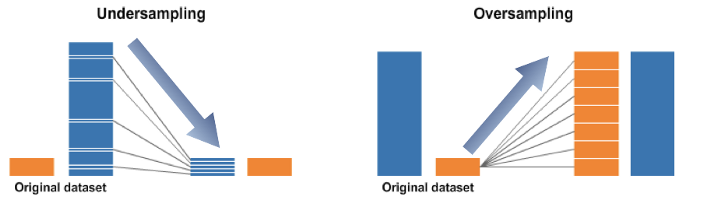
- 언더 샘플링
    - 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
    - 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄인 상태에서 학습을 수행하면 정상 레이블에 대해 제대로된 학습을 수행할 수 없는 문제가 발생할 수도 있음
- 오버 샘플링
    - 이상 데이터와 같은 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터 확보
    - 동일한 데이터를 단순 증식하면 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간 변경하여 증식
    - 대표적으로 SMOTE 방법이 있음
    - SMOTE : 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이나는 새로운 데이터 생성하는 방식

#### 데이터 일차 가공 및 모델 학습/예측/평가

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)
# V로 시작하는 피처들의 의미는 알 수 없음

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
# Time의 경우 데이터 생성 관련 작업용 속성이므로 제거
# Amount는 신용카드 트랜잭션 금액 의미
# Class : 0이면 정상, 1이면 사기
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DF 복사 후 Time 컬럼 삭제하고 복사된 DF 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [7]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    # Stratified sampling는 훈련데이터를 나눌 때 무작위로 샘플링을 하되, original dataset의 클래스 비율이 train, test set에서도 동일하게 유지되는 것을 보장한다
    X_train,X_test,y_train,y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train, X_test, y_train, y_test
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)

In [8]:
# 레이블이 비슷하게 분할됐는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [9]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score, f1_score,confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
# 모델 생성/학습/평가
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)
# 테스트 데이터로 측정 시 재현율 0.6149
# 실제 Positive를 Negative로 잘못 판단하면 영향이 큰 데이터이므로 재현율이 더 중요한 지표임

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1: 0.7194, AUC:0.9702


In [12]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트 입력받아 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [15]:
# 극도로 불균형한 레이블 값 분포도를 가지므로 LGBM 분류기 객체 생성시 boost_from_average=False로 파라미터 설정해야함
# True로 설정 시 재현율 및 ROC_AUC 성능 크게 저하
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 재현율 0.7568, AUC 0.979로 로지스틱 회귀보다 높은 수치를 나타냄

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


#### 데이터 분포도 변환 후 모델 학습/예측/평가
- 왜곡된 분포도 가지는 데이터 재가공

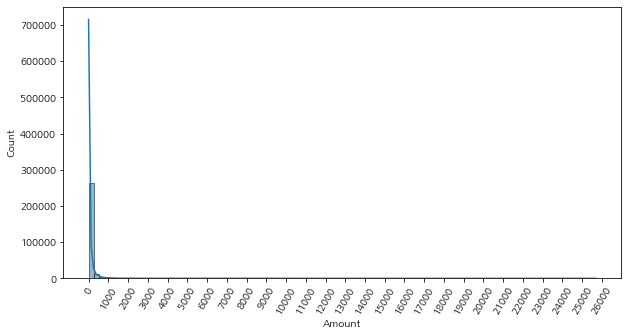

In [16]:
# 중요 피처 값의 분포도 살펴보기
# 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호함
# Amount 피처는 신용카드 사용 금액으로 중요한 속성일 가능성이 높음
import seaborn as sns

plt.figure(figsize=(10,5))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()
# 1000불 이하인 데이터가 대부분이며 26000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서
# 꼬리가 긴 형태의 분포 곡선을 가짐

In [21]:
# Amount를 표준 정규 분포 형태로 변환 후 로지스틱 회귀로 예측 성능 측정
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DF 맨 앞 칼럼으로 이비력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

# 로지스틱 회귀의 경우 정밀도와 재현율이 오히려 저하되었고, LightGBM의 경우 약간 저하되었지만 큰 성능상 변경은 없음 

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
LightGBM 예측 성능
오차 행렬
[[85248    47]
 [   69    79]]
정확도: 0.9986, 정밀도: 0.6270, 재현율: 0.5338, F1: 0.5766, AUC:0.7666


In [23]:
# 로그 변환 수행
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DF 맨 앞 칼럼으로 이비력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [24]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여줌

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
LightGBM 예측 성능
오차 행렬
[[85174   121]
 [  148     0]]
정확도: 0.9969, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC:0.4992


#### 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 찾기
    - IQR 방식(Inter Quantile Range)
    - 사분위 값의 편차를 이용하는 기법으로 흔히 박스 플롯 방식으로 시각화 가능
    - 사분위 : 전체 데이터를 값이 높은 순으로 정렬 후 1/4씩 구간으로 분할
    - IQR : Q1~Q3까지 범위(25%~75%)
    - IQR에 1.5 곱해 생성된 범위를 이용해 최대값과 최소값 결정 후 최대값을 초과하거나 최소값에 미달하는 데이터를 이상치로 간주함

<AxesSubplot:>

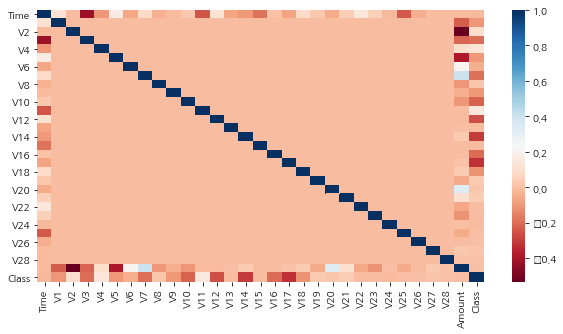

In [25]:
# 이상치 제거하기
plt.figure(figsize=(10,5))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
# Class 피처와 음의 상관관계가 높은 피처는 V14, V17

In [26]:
# V14에 대해서 이상치 제거하기
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [27]:
outlier_index = get_outlier(card_df, 'V14')
print(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [29]:
# 로그 변환 후 이상치 데이터 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DF 맨 앞 칼럼으로 이비력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 이상치 제거 후 예측 성능이 크게 향상됨

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
LightGBM 예측 성능
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534, F1: 0.7774, AUC:0.9219


#### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [30]:
# SMOTE 적용 시 반드시 학습 데이터 세트만 오버 샘플링 해야함
# 검증 데이터나 테스트 데이터를 오버 샘플링할 경우 결국 원본 데이터 세트가 아닌 데이터에서 검증을 수행하기 때문에 올바른 검증/테스트가 불가능함
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전:',X_train.shape, y_train.shape)
print('SMOTE 적용 후:',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포\n:',pd.Series(y_train_over).value_counts())
# 학습 데이터 세트가 2배에 가깝게 증식됐고, 레이블값의 분포가 동일하게 생성됨

SMOTE 적용 전: (199362, 29) (199362,)
SMOTE 적용 후: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포
: 1    199020
0    199020
Name: Class, dtype: int64


In [31]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)
# 재현율이 92.47%로 크게 증가했지만 정밀도가 5%로 급격하게 저하됨
# 실제 원본 데이터보다 너무 많은 Class=1 데이터 학습해 실제 데이터에서 예측을 지나치게 Class=1로 적용하여 정밀도가 떨어짐

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


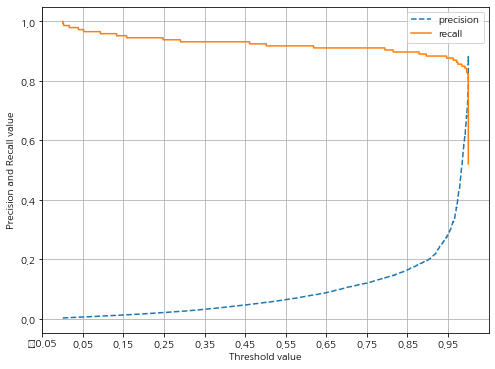

In [33]:
# 분류 결정 임계값에 따른 정밀도와 재현율 곡선 시각화
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])
# 정밀도는 점선, 재현율은 실선
# 임계값 0.99 이하에서는  재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대가 됨
# 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 
# 로지스틱 회귀모델의 경우 SMOTE 적용 후 올바른 예측 모델 생성되지 못함

In [34]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)
# 재현율이 이상치만 제거한 경우보다 높아졌지만 정밀도는 이전보다 낮아짐
# SMOTE 적용 시 재현율은 높아지나 정밀도는 낮아지는 것이 일반적임
# 재현율 지표를 높이는 것이 주 목표인 경우 SMOTE 적용하는 것이 적절함

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


### 11. 스태킹 앙상블
- 스태킹(Stacking) : 개별 여러 알고리즘을 서로 결합해 예측 결과 도출
- 개별 알고리즘으로 예측한 데이터 기반으로 다시 예측 수행
- 개별 알고리즘의 예측 결과 데이터 세트를 최종적 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습 수행하고 테스트 데이터 기반으로 다시 최종 예측 수행
- 두 종류의 모델 필요 : 개별적 기반 모델 / 최종 메타 모델
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트 만듦
- 현실 모델에 적용하는 경우는 많지 않으나 캐글과 같은 대회에 자주 사용함

In [99]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # 최종 모델

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data =cancer_data.data
y_label = cancer_data.target

X_train,X_test,y_train,y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [100]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

In [83]:
# 개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [84]:
# 개별 모델 예측 데이터 세트 생성 , 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다 부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.8947
에이다 부스트 정확도: 0.9561


In [85]:
# 반환된 예측 데이터 세트는 1차원 ndarray이므로 행 형태로 붙인 뒤 transpose()
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [86]:
# 최종 모델 학습/예측/평가
lr_final.fit(pred,y_test)
final = lr_final.predict(pred)

print('최종 메타모델 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타모델 정확도: 0.9737


#### CV 세트 기반 스태킹
- 과적합 개선을 위해 최종 메타 모델을 위한 데이터 세트 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트 이용

In [101]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        model.fit(X_tr , y_tr)       
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred , test_pred_mean

In [104]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [105]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print(X_train.shape, X_test.shape)
print(Stack_final_X_train.shape, Stack_final_X_test.shape)

(455, 30) (114, 30)
(455, 4) (114, 4)


In [106]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print(accuracy_score(y_test, stack_final))
# 스태킹을 이루는 모델은 최적으로 파라미터 튜닝한 상태에서 스태킹 모델을 만드는 것이 일반적임
# 분류뿐만 아니라 회귀에도 적용 가능

0.9736842105263158
